Strat 1: Pretraining BERT (MLM objective) on same data used for classifcation

In [7]:
!pip install datasets
!pip install evaluate

/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [8]:
"""Import support for Huggingface Models (Transformers)"""
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
)

import numpy as np
import tensorflow as tf
import torch
from datasets import Dataset, load_dataset, DatasetDict


import pandas as pd


In [9]:
"""Constants"""

# The dataset taken from https://huggingface.co/ESGBERT
dataset_url = "hf://datasets/ESGBERT/environmental_2k/environmental_2k.csv"

# The pretrained model checkpoint being used (2 layer, 512 hidden dimension, 8 attention heads)
model_checkpoint = "google/bert_uncased_L-2_H-512_A-8"

"""
Other models to try:
distilbert-base-uncased
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)


using device:  cpu


In [10]:
# Initialize tokenizer and model from the same model_checkpoint (so they're compatible)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
tokenizer

BertTokenizerFast(name_or_path='google/bert_uncased_L-2_H-512_A-8', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [12]:
"""sample model pipeline"""
sample = "test [MASK] some [MASK]thin [MASK]"

# Tokenize text
sample_tokenized = tokenizer([sample], return_tensors='pt', padding=True)

# run through model (tokenizer output is a dictionary with all input arguments for the model)
samp_out = mlm_model(**sample_tokenized)

print("output logits: ", samp_out.logits)

output logits:  tensor([[[ -9.4125,  -8.4637,  -9.1380,  ...,  -8.2151, -11.9307,  -7.7812],
         [ -9.7084,  -8.3756,  -8.8134,  ...,  -7.9416, -10.9808,  -8.9557],
         [ -8.2224,  -8.2958,  -7.6333,  ...,  -7.0930, -10.0589,  -4.0423],
         ...,
         [-10.0483, -10.6377,  -9.6757,  ...,  -8.6886, -10.9759,  -9.4402],
         [ -7.4171,  -9.1206,  -7.7921,  ...,  -8.2052,  -8.1395,  -6.1813],
         [ -8.9019,  -8.2693,  -7.9525,  ...,  -7.9172, -11.5575,  -7.4230]]],
       grad_fn=<ViewBackward0>)


In [13]:
"""Testing the model on it's masked language modelling objective"""

text = "This is a great [MASK]."

# Tokenize text and send through model
inputs = tokenizer(text, return_tensors="pt")
token_logits = mlm_model(**inputs).logits

# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[1, 0]
mask_token_logits = token_logits[0, mask_token_index, :]

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.argsort(mask_token_logits, descending=True)[:5].tolist()

# Output sentence with replaced mask for each of the top-5
for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

>>> This is a great event.
>>> This is a great place.
>>> This is a great idea.
>>> This is a great thing.
>>> This is a great deal.


# Preparing Data
Loading, splitting, tokenizing and chunking the data into batches for training

In [14]:
"""Read environment dataset from ESGBERT (2k labelled samples) from huggingface into a dataframe"""

# Change from 'env' to different column name if using a differentn dataset from https://huggingface.co/ESGBERT (eg. 'soc' for society)
df = pd.read_csv(dataset_url)[['text', 'env']]
df['env'] = df['env'].astype('int16')

In [15]:
# Construct arrow dataset from dataframe
ds = Dataset.from_pandas(df)

# Split into test and train
dataset = ds.train_test_split(train_size=0.8)

In [16]:
"""View samples (input-label pairs) of data"""
samp = dataset['train'].shuffle().select(range(5))
for row in samp:
    print(f"txt: {row['text']}, \nlabel: {row['env']}")

txt: It has been pleasing to see that financial controls remain robust and that high quality financial reporting continues to be delivered., 
label: 0
txt: We pride ourselves on providing a safe working environment for our employees.  , 
label: 0
txt: The conditions corres- pond to those applicable to independent third parties., 
label: 0
txt: This was contrasted by significant charges in our US wind energy business., 
label: 1
txt: Lack of transparency around future market developments, fears of recession, and the effects of intense price competition overshadowed the general economic recovery in this period., 
label: 0


In [17]:
"""Input Preprocessing"""

# Tokenizing function
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Process labels to make them multi-class (2 classes) for use of cross-entropy loss
def tupelize_labels(examples):
    result = examples
    result['label'] = [[val, 1-val] for val in examples['env']]
    return result

# Map transformations over datasets. Use batched=True to activate multithreading

# Prepare dataset for mlm pretraining--this only requires tokenized input text and the masked input ids and locations for labels
tokenized_datadict_for_mlm = dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "env"]
)

tokenized_dataset_classification = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_dataset_classification = tokenized_dataset_classification.map(
    tupelize_labels, batched=True
)

tokenized_datadict_for_mlm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 400/400 [00:00<00:00, 73665.05 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 400
    })
})

In [18]:
"""View of train dataset"""
pd.DataFrame(tokenized_datadict_for_mlm['train']).head()

,input_ids,token_type_ids,attention_mask,word_ids
0,"[101, 1999, 2760, 1010, 1996, 2177, 2506, 2049...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11..."
1,"[101, 2057, 2031, 2109, 1996, 1043, 25619, 877...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11..."
2,"[101, 2852, 24185, 11106, 14515, 2078, 2038, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, ..."
3,"[101, 2027, 2342, 2000, 2022, 2092, 2881, 1010...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 1..."
4,"[101, 1996, 2194, 1005, 1055, 5300, 2004, 2019...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."


<Axes: >

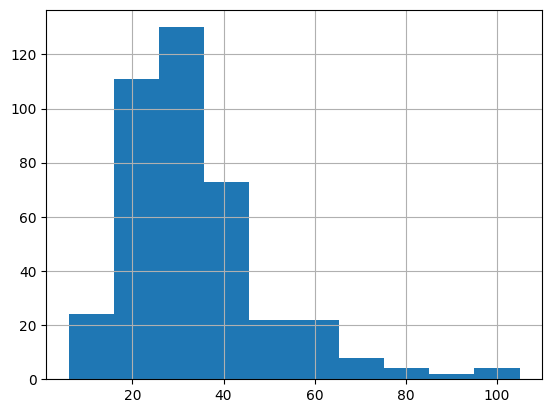

In [19]:
"""Analyse distribution of token lengths for setences in the dataset"""
tst = pd.DataFrame(tokenized_datadict_for_mlm['test'])['input_ids'].apply(len)
tst.hist()

In [50]:
"""Further data processing: group setnences into one long setnence and split into chunk-sized sentences"""
def get_stacked_dataset(dataset:Dataset, chunk_size=256):
    # Convert to dictionary
    dataset_dict = dataset.to_dict() if isinstance(dataset, Dataset) else dataset
    stacked_len = len(np.hstack(dataset_dict[list(dataset_dict.keys())[0]]))

    # First group all texts into one long text (np.hstack) before splitting into even sized chunks (np.hsplit)
    dataset_dict = {
        k:np.hsplit(np.hstack(dataset_dict[k])[:-(stacked_len%chunk_size)], stacked_len//chunk_size) for k in dataset_dict
    }
    # Create a column called labels -- this is for mlm objective, so it's the same as the input_ids
    dataset_dict['labels'] = dataset_dict['input_ids'].copy()

    # If fcn was called with a Dataset, return a Dataset; else return dict
    return Dataset.from_dict(dataset_dict) if isinstance(dataset, Dataset) else dataset_dict

# Test: Perform chunking, verify length of a chunk is what you set it to
test = get_stacked_dataset(dataset=tokenized_datadict_for_mlm['test'], chunk_size=256)
len(test[-1]['input_ids'])


256

In [51]:
"""Final dataset that we will be using to train and evaluate our model"""
tokenized_chunked_datadict = tokenized_datadict_for_mlm.map(get_stacked_dataset, batched=True)



Map: 100%|██████████| 400/400 [00:00<00:00, 8351.94 examples/s]


In [52]:
"""Brief check of a sample's token length"""
print("token-length of a sentence: ", len(tokenized_chunked_datadict["train"][0]["input_ids"]))
tokenized_chunked_datadict

token-length of a sentence:  256


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 213
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 52
    })
})

In [53]:
from transformers import DataCollatorForLanguageModeling, DataCollatorForWholeWordMask, DefaultDataCollator, DataCollatorWithPadding#DataCollatorForSe

"""
Data collation--default functions that prepare our data into batches for training. They also
do additional tasks like word masking (for mlm objective) and padding
"""
mask_probability = 0.15 # Original masking probability for BERT

# Simple data collator for MLM objective (masks each token with given probability)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mask_probability)

# Whole word masking (masks each word with given probability)
data_collator_wwm = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm_probability=mask_probability)

# Simple collator for our classification task (after pretraining)--just pads and batches input
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [58]:
"""Sample data collating inputs and labels (batch size of 2)"""
example_batch_size = 2
samples = [tokenized_chunked_datadict["train"][i] for i in range(example_batch_size)]

'''
Remove word_ids feature since DataCollatorForMaskedLM does not expect this argument -- uncomment
if using regular data collator
'''
# for sample in samples:
#     _ = sample.pop("word_ids")

# Output input (masked text)
print("inputs: ")
for chunk in data_collator_wwm(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

# Output labels (a vector of tokens the same length as input but with masked tokens replaced with the original values, and all non-masked tokens as -100)
print("\nlabels: ")
for chunk in data_collator_wwm(samples)["labels"]:
    print(f"\n'>>> {(chunk)}'")


inputs: 

'>>> [CLS] in 2018 [MASK] the group continued its internationalisation strategy with the opening of an office in new york in 2018 and tokyo in 2019. [SEP] [CLS] we [MASK] used the ghg protocol corporate accounting and [MASK] standard ( [MASK] [MASK] ). [SEP] [CLS] dr woehrmann has also assumed the responsibility for setting vacation overall dws [MASK] esg and sustainability strategy. [SEP] [CLS] they [MASK] to [MASK] [MASK] designed, [MASK] need to bemarketed, they need to be attractively [MASK] and they need to performwell. [SEP] [CLS] the [MASK]'[MASK] values as an employer are based on fair and transparent treatment of all employees, regardless of gender [MASK] race, [MASK], religion, sexual orientation, age, disability, marital status [MASK] family status. [SEP] [CLS] the awards total £1, 070 [MASK] 000 [MASK] [MASK] be converted into a number [MASK] shares subject [MASK] award based [MASK] [MASK] share price following the announcement of the [MASK] ’ s results [MASK] [MA

# Training - MLM

In [62]:
from transformers import TrainingArguments

batch_size = 64

# Show the training loss with every epoch
logging_steps = len(tokenized_chunked_datadict["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

# Initialize training arguments
training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-esg_env",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=False,
    use_cpu=(device==torch.device('cpu')),
    # fp16=True, # on gpu
    logging_steps=logging_steps,
)

/opt/homebrew/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
from transformers import Trainer

"""Set up trainer"""
trainer_mlm = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=tokenized_chunked_datadict["train"],
    eval_dataset=tokenized_chunked_datadict["test"],
    data_collator=data_collator_wwm, # experiment with the other data collator for masked language modelling
    tokenizer=tokenizer,
)

In [ ]:
"""Compute perplexity of model (prior to pretraining; this is just the BERT model checkpoint trained on natural language english)"""
import math

# Evaluate model
eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 29.82


In [ ]:
"""train model"""
trainer_mlm.train()

'train model'

In [ ]:
"""Evaluate perplexity again after training--is there an improvement?"""
eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 30.80


In [ ]:
# view model config
print(mlm_model.config)

# Save model (this is not the complete classifier, just the pretrained MLM model) FIXME uncomment save line for trying
mlm_model_dirname = f'saved_mlm_models/finetuned-{mlm_model.config.name_or_path.replace("google/", "")}'
# mlm_model.save_pretrained(mlm_model_dirname)

BertConfig {
  "_name_or_path": "google/bert_uncased_L-2_H-512_A-8",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
"""loading model and retreiving basemodel (encoder, without MLM head)"""
"""If loading saved model, uncomment"""
# loaded_mlm_model = AutoModelForMaskedLM.from_pretrained(mlm_model_dirname)
# base_model = loaded_model.base_model

base_model = mlm_model.base_model


# Training - Classifier
adding a classifier head on top of the BERT encoder pretrianed on the previous MLM task (we discard the MLM head)

In [65]:
"""BERT Classifier module (to stack on top of BERT encoder)"""

class BertClassifier(torch.nn.Module):
    def __init__(self, base_bert_model, num_classes=2):
        super(BertClassifier, self).__init__()

        # The base (pre-trained) bert encoder
        self.base_model = base_bert_model

        # Custom classification head
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(self.base_model.config.max_position_embeddings, num_classes) # output features from bert is 512 and 2 is ur number of labels

    def forward(self, input_ids, attention_mask, labels=None):
        # Get encoded representation of input
        outputs = self.base_model(input_ids, attention_mask=attention_mask)

        # Pass through classification head (dropout + linear layer)
        outputs = self.dropout(outputs.last_hidden_state[:,0,:]) # This returns the last hidden state of the token corresponding to [CLS] (see BERT paper)
        outputs = self.linear(outputs)

        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(outputs.float(), labels.float())
            print("loss: ", loss)

        return (loss, outputs) if labels is not None else (outputs,)


In [66]:
"""Intantiate and view model architecture"""
classifier_model = BertClassifier(base_bert_model=mlm_model.base_model)
classifier_model

BertClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elemen

In [67]:
import evaluate

metric = evaluate.load("accuracy")

# method to compute accuracy:
def compute_metrics(eval_pred):
    labels, logits = eval_pred
    predictions = np.argmax(logits, axis=1)#torch.softmax(torch.tensor(logits).float(), dim=1)  #np.argmax(logits, axis=1)
    references = np.argmax(labels, axis=1)

    return metric.compute(predictions=(predictions), references=references)#(labels))

# Set up training args for classifier
training_args_classifier = TrainingArguments(output_dir="train_out", eval_strategy="epoch", use_cpu=(device==torch.device('cpu')))
trainer_classifier = Trainer(
    model=classifier_model,
    args=training_args_classifier,
    train_dataset=tokenized_dataset_classification['train'],
    eval_dataset=tokenized_dataset_classification['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator_classification,
)



In [68]:
"""Testing evaluate, before training the (randomly initialized) classification head"""
trainer_classifier.evaluate()

loss:  tensor(0.6751)


  8%|▊         | 4/50 [00:00<00:01, 36.40it/s]

loss:  tensor(0.5814)
loss:  tensor(0.8221)
loss:  tensor(0.7661)
loss:  tensor(0.5474)
loss:  tensor(0.6599)
loss:  tensor(0.6539)


 16%|█▌        | 8/50 [00:00<00:01, 26.85it/s]

loss:  tensor(0.6625)
loss:  tensor(0.6309)


 22%|██▏       | 11/50 [00:00<00:01, 22.79it/s]

loss:  tensor(0.6733)
loss:  tensor(0.8190)


 28%|██▊       | 14/50 [00:00<00:01, 24.80it/s]

loss:  tensor(0.7908)
loss:  tensor(0.5958)
loss:  tensor(1.0161)
loss:  tensor(0.4450)


 34%|███▍      | 17/50 [00:00<00:01, 26.06it/s]

loss:  tensor(0.6680)
loss:  tensor(0.4805)


 40%|████      | 20/50 [00:00<00:01, 24.03it/s]

loss:  tensor(0.7774)
loss:  tensor(0.6140)
loss:  tensor(0.5334)


 46%|████▌     | 23/50 [00:00<00:01, 24.74it/s]

loss:  tensor(0.8642)
loss:  tensor(0.9394)
loss:  tensor(0.5476)


 52%|█████▏    | 26/50 [00:01<00:00, 25.16it/s]

loss:  tensor(0.6362)
loss:  tensor(0.7630)
loss:  tensor(0.5928)
loss:  tensor(0.6027)


 64%|██████▍   | 32/50 [00:01<00:00, 24.19it/s]

loss:  tensor(0.5756)
loss:  tensor(0.5541)
loss:  tensor(0.7781)
loss:  tensor(0.7285)
loss:  tensor(0.6778)
loss:  tensor(0.7406)


 76%|███████▌  | 38/50 [00:01<00:00, 24.61it/s]

loss:  tensor(0.6421)
loss:  tensor(0.6367)
loss:  tensor(0.5263)
loss:  tensor(0.6118)
loss:  tensor(0.6730)
loss:  tensor(0.7134)


 92%|█████████▏| 46/50 [00:01<00:00, 29.74it/s]

loss:  tensor(0.6183)
loss:  tensor(0.7008)
loss:  tensor(0.4449)
loss:  tensor(0.5513)
loss:  tensor(0.4626)
loss:  tensor(0.6942)
loss:  tensor(0.6935)


100%|██████████| 50/50 [00:01<00:00, 25.10it/s]

loss:  tensor(0.7337)
loss:  tensor(0.5875)
loss:  tensor(0.7650)
loss:  tensor(0.8626)


{'eval_loss': 0.6666243076324463,
 'eval_accuracy': 0.6675,
 'eval_runtime': 3.4215,
 'eval_samples_per_second': 116.909,
 'eval_steps_per_second': 14.614}

In [ ]:
"""Train classifier"""
trainer_classifier.train()

loss:  tensor(0.6856, device='cuda:0', grad_fn=<DivBackward1>)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.225425,0.927500
2,No log,0.234540,0.942500
3,0.244000,0.255887,0.937500


loss:  tensor(0.6606, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4413, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7301, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7089, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3245, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3121, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.9461, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.2447, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.2328, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4028, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.1116, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.4247, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7310, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3727, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6618, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4743, device='cuda:0', grad_fn=<DivBack

loss:  tensor(0.0533, device='cuda:0')
loss:  tensor(0.0169, device='cuda:0')
loss:  tensor(0.0637, device='cuda:0')
loss:  tensor(0.0056, device='cuda:0')
loss:  tensor(0.0646, device='cuda:0')
loss:  tensor(0.4878, device='cuda:0')
loss:  tensor(0.1867, device='cuda:0')
loss:  tensor(0.0070, device='cuda:0')
loss:  tensor(0.0370, device='cuda:0')
loss:  tensor(0.0028, device='cuda:0')
loss:  tensor(0.3342, device='cuda:0')
loss:  tensor(0.0330, device='cuda:0')
loss:  tensor(0.0174, device='cuda:0')
loss:  tensor(0.3381, device='cuda:0')
loss:  tensor(0.4508, device='cuda:0')
loss:  tensor(1.0549, device='cuda:0')
loss:  tensor(0.6642, device='cuda:0')
loss:  tensor(0.1714, device='cuda:0')
loss:  tensor(0.2806, device='cuda:0')
loss:  tensor(0.7142, device='cuda:0')
loss:  tensor(0.0082, device='cuda:0')
loss:  tensor(0.1447, device='cuda:0')
loss:  tensor(0.8699, device='cuda:0')
loss:  tensor(0.0324, device='cuda:0')
loss:  tensor(0.0038, device='cuda:0')
loss:  tensor(0.1501, dev

TrainOutput(global_step=600, training_loss=0.22315019925435384, metrics={'train_runtime': 20.8044, 'train_samples_per_second': 230.72, 'train_steps_per_second': 28.84, 'total_flos': 0.0, 'train_loss': 0.22315019925435384, 'epoch': 3.0})

# Testing

In [ ]:
"""Final evaluation"""
trainer_classifier.evaluate()

loss:  tensor(1.7455, device='cuda:0')


loss:  tensor(0.0095, device='cuda:0')
loss:  tensor(0.0074, device='cuda:0')
loss:  tensor(0.0467, device='cuda:0')
loss:  tensor(0.0016, device='cuda:0')
loss:  tensor(0.0113, device='cuda:0')
loss:  tensor(0.7748, device='cuda:0')
loss:  tensor(0.5851, device='cuda:0')
loss:  tensor(0.0010, device='cuda:0')
loss:  tensor(0.0460, device='cuda:0')
loss:  tensor(0.0005, device='cuda:0')
loss:  tensor(0.6181, device='cuda:0')
loss:  tensor(0.0048, device='cuda:0')
loss:  tensor(0.0017, device='cuda:0')
loss:  tensor(0.4561, device='cuda:0')
loss:  tensor(0.7495, device='cuda:0')
loss:  tensor(0.9666, device='cuda:0')
loss:  tensor(0.9604, device='cuda:0')
loss:  tensor(0.0304, device='cuda:0')
loss:  tensor(0.5290, device='cuda:0')
loss:  tensor(0.8937, device='cuda:0')
loss:  tensor(0.0015, device='cuda:0')
loss:  tensor(0.0271, device='cuda:0')
loss:  tensor(1.1651, device='cuda:0')
loss:  tensor(0.0158, device='cuda:0')
loss:  tensor(0.0005, device='cuda:0')
loss:  tensor(0.1919, dev

{'eval_loss': 0.25588664412498474,
 'eval_accuracy': 0.9375,
 'eval_runtime': 0.3812,
 'eval_samples_per_second': 1049.202,
 'eval_steps_per_second': 131.15,
 'epoch': 3.0}

In [ ]:
"""Set up input processing for inference (tokenization and tensorization)"""
def process_model_input_for_inference(input, tokenizer):
    tokenized = tokenizer(input)
    return {'input_ids':torch.tensor([tokenized['input_ids']]).to(device), 'attention_mask':torch.tensor([tokenized['attention_mask']])}





In [ ]:
"""Sample inference on some sentences"""
sample_inputs = ["in the last quarter we upped our social impact by a lot",
                 "in the last quarter we upped our environmental impact by a lot",
                 "some random sentence",
                 "this is related to environmental governence.",
                 'That’s why our strategy looks much more holistically at the health of local watersheds.',
                 'To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.',
                 'We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.']

for inp in sample_inputs:
    # Remember model was trained on outputs that look like [1, 0] for 1 and [0, 1] for 0
    print(f'{inp}: {1-np.argmax(classifier_model(**process_model_input_for_inference(inp, tokenizer=tokenizer))[0].detach().cpu().numpy())}')


in the last quarter we upped our social impact by a lot: 0
in the last quarter we upped our environmental impact by a lot: 1
some random sentence: 0
this is related to environmental governence.: 1
That’s why our strategy looks much more holistically at the health of local watersheds.: 1
To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.: 0
We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.: 0


In [ ]:
# Save classifier model FIXME uncomment to use
# torch.save(classifier_model, 'saved_classifier_models/my_esg_env_classifier_1')